In [1]:
# Downloading, extraction, organization
import requests
import os
import shutil
import glob
import io
import zipfile
import patoolib

# Dataset splitting
from collections import Counter
from sklearn.model_selection import train_test_split
import random
random.seed(0)

# Visualization
import cv2
from matplotlib import pyplot as plt

# Stanford 40
### Download the dataset

In [2]:
response_stanford40_imgs = requests.get("http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip")
if response_stanford40_imgs.status_code == 200:
    print("Data download successful")
else:
    print("Data download failed")

response_stanford40_splits = requests.get("http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip")
if response_stanford40_splits.status_code == 200:
    print("Splits download successful")
else:
    print("Splits download failed")

Data download successful
Splits download successful


### Extract data

In [3]:
if os.path.exists("Stanford40"):
    shutil.rmtree("Stanford40")

with zipfile.ZipFile(io.BytesIO(response_stanford40_imgs.content), "r") as zip_ref:
    zip_ref.extractall("Stanford40")

with zipfile.ZipFile(io.BytesIO(response_stanford40_splits.content), "r") as zip_ref:
    zip_ref.extractall("Stanford40")

### Read the train and test splits, combine them, and make better splits of train, validation, and test

In [4]:
def output_list_to_file(file_path, list):
    with open(file_path, "w") as f:
        for item in list:
            f.write(f"{item}\n")

In [5]:
def oversample_files_labels(files, labels):
    files_labels = list(zip(files, labels))
    class_distribution = Counter(labels)
    target_count = max(class_distribution.values())
    files_labels_osamp = []
    for label in class_distribution:
        class_files_labels = [file_label for file_label in files_labels if file_label[1] == label]
        additional_needed = target_count - class_distribution[label]
        # Duplicate instances randomly if needed
        class_files_labels_osamp = class_files_labels + random.choices(class_files_labels, k=additional_needed)
        files_labels_osamp.extend(class_files_labels_osamp)
    files_osamp, labels_osamp = zip(*files_labels_osamp)

    return files_osamp, labels_osamp

In [6]:
keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse",
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]

with open(os.path.join("Stanford40", "ImageSplits", "train.txt"), "r") as f:
    # Not using these splits, will be split again after
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if "_".join(file_name.split("_")[:-1]) in keep_stanford40]
    train_labels = ["_".join(name.split("_")[:-1]) for name in train_files]

with open(os.path.join("Stanford40", "ImageSplits", "test.txt"), "r") as f:
    # Not using these splits, will be split again after
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if "_".join(file_name.split("_")[:-1]) in keep_stanford40]
    test_labels = ["_".join(name.split("_")[:-1]) for name in test_files]

# Combine the splits and split again to keep more images in the training set than the test set
all_files = train_files + test_files
all_labels = train_labels + test_labels
# 90% train and 10% test split
train_val_files, test_files, train_val_labels, test_labels = train_test_split(all_files, all_labels,
                                                                              test_size=0.1, random_state=0, stratify=all_labels)
# 10% of train as validation
train_files, val_files, train_labels, val_labels = train_test_split(train_val_files, train_val_labels,
                                                                    test_size=0.1, random_state=0, stratify=train_val_labels)

# Oversampling process to make classes equal
train_files_osamp, train_labels_osamp = oversample_files_labels(train_files, train_labels)
val_files_osamp, val_labels_osamp = oversample_files_labels(val_files, val_labels)
train_val_files_osamp = train_files_osamp + val_files_osamp
train_val_labels_osamp = train_labels_osamp + val_labels_osamp

print(f"Train + Validation distribution ({len(train_val_files)}):\n{list(Counter(sorted(train_val_labels)).items())}\n")
print(f"Oversampled Train + Validation distribution ({len(train_val_files_osamp)}):\n{list(Counter(sorted(train_val_labels_osamp)).items())}\n")
print(f"Train distribution ({len(train_files)}):\n{list(Counter(sorted(train_labels)).items())}\n")
print(f"Oversampled Train distribution ({len(train_files_osamp)}):\n{list(Counter(sorted(train_labels_osamp)).items())}\n")
print(f"Validation distribution ({len(val_files)}):\n{list(Counter(sorted(val_labels)).items())}\n")
print(f"Oversampled Validation distribution ({len(val_files_osamp)}):\n{list(Counter(sorted(val_labels_osamp)).items())}\n")
print(f"Test distribution  ({len(test_files)}):\n{list(Counter(sorted(test_labels)).items())}\n")
action_categories = sorted(list(set(train_val_labels)))
print(f"Action categories ({len(action_categories)}):\n{action_categories}")

output_list_to_file(os.path.join("Stanford40", "train_val_files.txt"), train_val_files)
output_list_to_file(os.path.join("Stanford40", "train_val_labels.txt"), train_val_labels)
output_list_to_file(os.path.join("Stanford40", "train_val_files_osamp.txt"), train_val_files_osamp)
output_list_to_file(os.path.join("Stanford40", "train_val_labels_osamp.txt"), train_val_labels_osamp)
output_list_to_file(os.path.join("Stanford40", "train_files.txt"), train_files)
output_list_to_file(os.path.join("Stanford40", "train_labels.txt"), train_labels)
output_list_to_file(os.path.join("Stanford40", "train_files_osamp.txt"), train_files_osamp)
output_list_to_file(os.path.join("Stanford40", "train_labels_osamp.txt"), train_labels_osamp)
output_list_to_file(os.path.join("Stanford40", "val_files.txt"), val_files)
output_list_to_file(os.path.join("Stanford40", "val_labels.txt"), val_labels)
output_list_to_file(os.path.join("Stanford40", "val_files_osamp.txt"), val_files_osamp)
output_list_to_file(os.path.join("Stanford40", "val_labels_osamp.txt"), val_labels_osamp)
output_list_to_file(os.path.join("Stanford40", "test_files.txt"), test_files)
output_list_to_file(os.path.join("Stanford40", "test_labels.txt"), test_labels)

Train + Validation distribution (2733):
[('applauding', 256), ('climbing', 265), ('drinking', 230), ('jumping', 265), ('pouring_liquid', 180), ('riding_a_bike', 264), ('riding_a_horse', 266), ('running', 226), ('shooting_an_arrow', 193), ('smoking', 217), ('throwing_frisby', 182), ('waving_hands', 189)]

Oversampled Train + Validation distribution (3192):
[('applauding', 266), ('climbing', 266), ('drinking', 266), ('jumping', 266), ('pouring_liquid', 266), ('riding_a_bike', 266), ('riding_a_horse', 266), ('running', 266), ('shooting_an_arrow', 266), ('smoking', 266), ('throwing_frisby', 266), ('waving_hands', 266)]

Train distribution (2459):
[('applauding', 230), ('climbing', 238), ('drinking', 207), ('jumping', 239), ('pouring_liquid', 162), ('riding_a_bike', 238), ('riding_a_horse', 239), ('running', 203), ('shooting_an_arrow', 174), ('smoking', 195), ('throwing_frisby', 164), ('waving_hands', 170)]

Oversampled Train distribution (2868):
[('applauding', 239), ('climbing', 239), ('d

### Visualize images from the dataset with their labels

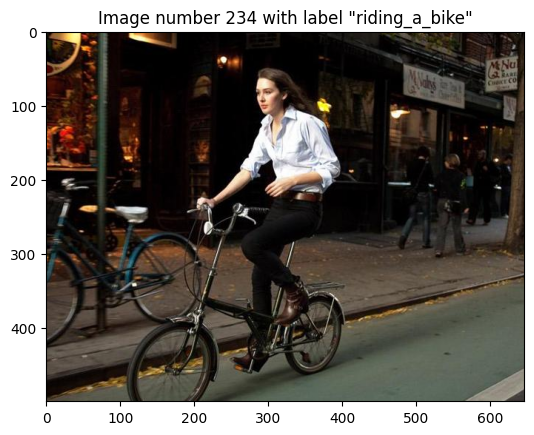

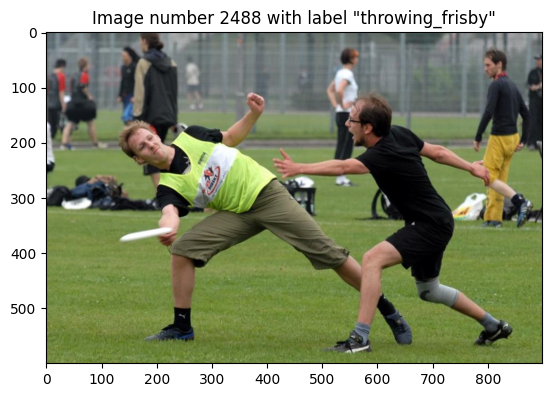

In [7]:
image_nums = [234, 2488]
for image_num in image_nums:
    img = cv2.imread(os.path.join("Stanford40", "JPEGImages", train_val_files[image_num]))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(f'Image number {image_num} with label "{train_val_labels[image_num]}"')
    plt.imshow(img_rgb)
    plt.show()

# Human Motion Database 51 (HMDB51)
### Download the dataset

In [8]:
if os.path.exists("HMDB51"):
    shutil.rmtree("HMDB51")

response_hmdb51_imgs = requests.get("http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar")
if response_hmdb51_imgs.status_code == 200:
    print("Data download successful")
    os.makedirs("HMDB51", exist_ok=True)
    with open(os.path.join("HMDB51", "hmdb51_org.rar"), "wb") as f:
        f.write(response_hmdb51_imgs.content)
else:
    print("Data download failed")
    
response_hmdb51_splits = requests.get("http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar")
if response_hmdb51_splits.status_code == 200:
    print("Splits download successful")
    os.makedirs("HMDB51", exist_ok=True)
    with open(os.path.join("HMDB51", "test_train_splits.rar"), "wb") as f:
        f.write(response_hmdb51_splits.content)
else:
    print("Splits download failed")

Data download successful
Splits download successful


### Extract and organize data

In [9]:
data_path = os.path.join("HMDB51", "video_data")
data_rar_path = os.path.join("HMDB51", "hmdb51_org.rar")
splits_path = os.path.join("HMDB51", "test_train_splits")
splits_rar_path = os.path.join("HMDB51", "test_train_splits.rar")
os.makedirs(data_path, exist_ok=True)
os.makedirs(splits_path, exist_ok=True)

temp_path = os.path.join("HMDB51", "temp")
os.makedirs(temp_path, exist_ok=True)
patoolib.extract_archive(splits_rar_path, outdir=temp_path)
for file in os.listdir(os.path.join(temp_path, "testTrainMulti_7030_splits")):
    shutil.move(os.path.join(temp_path, "testTrainMulti_7030_splits", file), splits_path)
shutil.rmtree(temp_path)
os.remove(splits_rar_path)

patoolib.extract_archive(data_rar_path, outdir=data_path)
os.remove(data_rar_path)

keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"]

for file in os.listdir(data_path):
    folder_name = file.split(".")[0]
    if folder_name in keep_hmdb51:
        # Extract only the relevant classes
        os.makedirs(os.path.join(data_path, folder_name), exist_ok=True)
        patoolib.extract_archive(os.path.join(data_path, file), outdir=data_path)
    os.remove(os.path.join(data_path, file))

patool: Extracting HMDB51\test_train_splits.rar ...
patool: running "C:\Program Files\7-Zip\7z.EXE" x -oHMDB51\temp -- HMDB51\test_train_splits.rar
patool:     with creationflags=134217728
patool: ... HMDB51\test_train_splits.rar extracted to `HMDB51\temp'.
patool: Extracting HMDB51\hmdb51_org.rar ...
patool: running "C:\Program Files\7-Zip\7z.EXE" x -oHMDB51\video_data -- HMDB51\hmdb51_org.rar
patool:     with creationflags=134217728
patool: ... HMDB51\hmdb51_org.rar extracted to `HMDB51\video_data'.
patool: Extracting HMDB51\video_data\clap.rar ...
patool: running "C:\Program Files\7-Zip\7z.EXE" x -oHMDB51\video_data -- HMDB51\video_data\clap.rar
patool:     with creationflags=134217728
patool: ... HMDB51\video_data\clap.rar extracted to `HMDB51\video_data'.
patool: Extracting HMDB51\video_data\climb.rar ...
patool: running "C:\Program Files\7-Zip\7z.EXE" x -oHMDB51\video_data -- HMDB51\video_data\climb.rar
patool:     with creationflags=134217728
patool: ... HMDB51\video_data\climb.

### Split the dataset into train, validation, and test

In [10]:
# Train set tagged with ID 1, test set tagged with ID 2
TRAIN_TAG, TEST_TAG = 1, 2
train_val_files, test_files = [], []
train_val_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join("HMDB51", "test_train_splits", split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)
for file_path in annotation_paths:
    class_name = "_".join(file_path.split(os.sep)[-1].split("_")[:-2])
    if class_name not in keep_hmdb51:
        continue  # Skipping the classes that are not used
    with open(file_path) as fid:
        lines = fid.readlines()
    for line in lines:
        video_file_name, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_val_files.append(video_file_name)
            train_val_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_file_name)
            test_labels.append(class_name)

# 10% of train as validation
train_files, val_files, train_labels, val_labels = train_test_split(train_val_files, train_val_labels,
                                                                    test_size=0.1, random_state=0, stratify=train_val_labels)

print(f"Train + Validation distribution ({len(train_val_files)}):\n{list(Counter(sorted(train_val_labels)).items())}\n")
print(f"Train distribution ({len(train_files)}):\n{list(Counter(sorted(train_labels)).items())}\n")
print(f"Validation distribution ({len(val_files)}):\n{list(Counter(sorted(val_labels)).items())}\n")
print(f"Test distribution  ({len(test_files)}):\n{list(Counter(sorted(test_labels)).items())}\n")
action_categories = sorted(list(set(train_val_labels)))
print(f"Action categories ({len(action_categories)}):\n{action_categories}")

output_list_to_file(os.path.join("HMDB51", "train_val_files.txt"), train_val_files)
output_list_to_file(os.path.join("HMDB51", "train_val_labels.txt"), train_val_labels)
output_list_to_file(os.path.join("HMDB51", "train_files.txt"), train_files)
output_list_to_file(os.path.join("HMDB51", "train_labels.txt"), train_labels)
output_list_to_file(os.path.join("HMDB51", "val_files.txt"), val_files)
output_list_to_file(os.path.join("HMDB51", "val_labels.txt"), val_labels)
output_list_to_file(os.path.join("HMDB51", "test_files.txt"), test_files)
output_list_to_file(os.path.join("HMDB51", "test_labels.txt"), test_labels)

Train + Validation distribution (840):
[('clap', 70), ('climb', 70), ('drink', 70), ('jump', 70), ('pour', 70), ('ride_bike', 70), ('ride_horse', 70), ('run', 70), ('shoot_bow', 70), ('smoke', 70), ('throw', 70), ('wave', 70)]

Train distribution (756):
[('clap', 63), ('climb', 63), ('drink', 63), ('jump', 63), ('pour', 63), ('ride_bike', 63), ('ride_horse', 63), ('run', 63), ('shoot_bow', 63), ('smoke', 63), ('throw', 63), ('wave', 63)]

Validation distribution (84):
[('clap', 7), ('climb', 7), ('drink', 7), ('jump', 7), ('pour', 7), ('ride_bike', 7), ('ride_horse', 7), ('run', 7), ('shoot_bow', 7), ('smoke', 7), ('throw', 7), ('wave', 7)]

Test distribution  (360):
[('clap', 30), ('climb', 30), ('drink', 30), ('jump', 30), ('pour', 30), ('ride_bike', 30), ('ride_horse', 30), ('run', 30), ('shoot_bow', 30), ('smoke', 30), ('throw', 30), ('wave', 30)]

Action categories (12):
['clap', 'climb', 'drink', 'jump', 'pour', 'ride_bike', 'ride_horse', 'run', 'shoot_bow', 'smoke', 'throw', 'wa